<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#&quot;Implémentez-un-modèle-de-scoring&quot;" data-toc-modified-id="&quot;Implémentez-un-modèle-de-scoring&quot;-1">"Implémentez un modèle de scoring"</a></span><ul class="toc-item"><li><span><a href="#0-Preliminaries" data-toc-modified-id="0-Preliminaries-1.1">0 Preliminaries</a></span><ul class="toc-item"><li><span><a href="#0.0-Importing-Packages-and-Modules" data-toc-modified-id="0.0-Importing-Packages-and-Modules-1.1.1">0.0 Importing Packages and Modules</a></span></li><li><span><a href="#0.1-Importing-data-and-model" data-toc-modified-id="0.1-Importing-data-and-model-1.1.2">0.1 Importing data and model</a></span></li></ul></li><li><span><a href="#1-Customer's-choice" data-toc-modified-id="1-Customer's-choice-1.2">1 Customer's choice</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Score-and-decision-according-to-the-best-model" data-toc-modified-id="Score-and-decision-according-to-the-best-model-1.2.0.1">Score and decision according to the best model</a></span></li><li><span><a href="#Nearest-Neighbors" data-toc-modified-id="Nearest-Neighbors-1.2.0.2">Nearest Neighbors</a></span></li></ul></li></ul></li><li><span><a href="#2-Data-Visualization-after-preprocessing-(2D-projection)" data-toc-modified-id="2-Data-Visualization-after-preprocessing-(2D-projection)-1.3">2 Data Visualization after preprocessing (2D projection)</a></span></li><li><span><a href="#3-Boxplot-of-10-main-variables" data-toc-modified-id="3-Boxplot-of-10-main-variables-1.4">3 Boxplot of 10 main variables</a></span></li><li><span><a href="#4-SHAP-graphs" data-toc-modified-id="4-SHAP-graphs-1.5">4 SHAP graphs</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Feature-importance-for-the-20-nearest-neighbors-of-the-customer" data-toc-modified-id="Feature-importance-for-the-20-nearest-neighbors-of-the-customer-1.5.0.1">Feature importance for the 20 nearest neighbors of the customer</a></span></li><li><span><a href="#Probability-prediction-for-class-1" data-toc-modified-id="Probability-prediction-for-class-1-1.5.0.2">Probability prediction for class 1</a></span></li><li><span><a href="#Waterfall-plot-for-one-customer" data-toc-modified-id="Waterfall-plot-for-one-customer-1.5.0.3">Waterfall plot for one customer</a></span></li><li><span><a href="#Forceplot" data-toc-modified-id="Forceplot-1.5.0.4">Forceplot</a></span></li><li><span><a href="#Beeswarm-plot-for-20-neighbors-and-the-customer" data-toc-modified-id="Beeswarm-plot-for-20-neighbors-and-the-customer-1.5.0.5">Beeswarm plot for 20 neighbors and the customer</a></span></li></ul></li></ul></li></ul></li></ul></div>

# "Implémentez un modèle de scoring"
_Building and optimizing a classification model_

References used for this notebook:


## 0 Preliminaries

### 0.0 Importing Packages and Modules

In [1]:
import io
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

In [15]:
from P7_functions_new import *
# from custtransformer import CustTransformer

In [3]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
    pd.set_option(k,v)

### 0.1 Importing data and model

In [4]:
# import cleaned data and model

import joblib

with open('..\\PICKLES\\dict_cleaned.pkl', 'rb') as file:
    dict_cleaned = joblib.load(file)
with open('..\\PICKLES\\P7_04_bestmodel_thresh.pkl', 'rb') as file:
    best_model, thresh = joblib.load(file)
# with open('..\\PICKLES\\P7_04_bestmodel_thresh.pkl', 'rb') as file:
#     best_model, thresh = joblib.load(file)

In [5]:
# put data from dictionary into variables
X_train = dict_cleaned['X_train']
y_train = dict_cleaned['y_train']
X_test = dict_cleaned['X_test']

In [6]:
# split the steps of the best pipeline
preproc_step = best_model.named_steps['preproc']
featsel_step = best_model.named_steps['featsel']
clf_step = best_model.named_steps['clf']

# compute the preprocessed data (encoding and standardization)
X_tr_prepro = preproc_step.transform(X_train)
X_te_prepro = preproc_step.transform(X_test)

# get the name of the columns after encoding
preproc_cols = X_tr_prepro.columns

# get the name of the columns selected using SelectFromModel
featsel_cols = preproc_cols[featsel_step.get_support()]

# compute the data to be used by the best classifier
X_tr_featsel = X_tr_prepro[featsel_cols]
X_te_featsel = X_te_prepro[featsel_cols]

## 1 Customer's choice

In [7]:
# random sample of customers

N =5000
random_samp = X_train.sample(N).index

In [8]:
# select one customer among the test sample

X_cust = X_test.sample(1)
customer_idx = X_cust.index.values[0]

#### Score and decision according to the best model

In [9]:
thresh

0.5306122448979591

In [10]:
# compute result using the whole pipeline
score_cust = best_model.predict_proba(X_cust)[:,1][0]
bool_cust = score_cust >= thresh

# # compute the best model using preprocessed data and last step of the best pipeline (classifier)
# score_cust = clf_step.predict_proba(X_tr_featsel.loc[customer_idx: customer_idx])[:,1][0]
# bool_cust = score_cust <= thresh

In [11]:
score_cust, bool_cust

(0.2526851366232114, False)

#### Nearest Neighbors

In [12]:
# get indices of the 20 nearest neighbors in the X_tr dataframe 

from sklearn.neighbors import NearestNeighbors

# fit nearest neighbors among the selection

neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(X_tr_featsel.loc[random_samp])

idx = neigh.kneighbors(X=X_te_featsel.loc[customer_idx: customer_idx],
                       n_neighbors=20,
                       return_distance=False).ravel()

nearest_cust_idx = list(X_tr_featsel.loc[random_samp].iloc[idx].index)

## 2 Data Visualization after preprocessing (2D projection)

In [13]:
from random  import sample
n_display = 100
display_samp = sample(set(random_samp), 10)

In [16]:
# Computes the axes for projection with centers

dict_proj, dict_proj_centers, _ = prepare_2D_axes(X_tr_featsel.loc[random_samp],
                                                  y_train.loc[random_samp],
                                                  ser_clust=y_train.loc[random_samp],
                                                  proj=['t-SNE'],
                                                  model=None,
                                                  centers_on=True,
                                                  random_state=14)

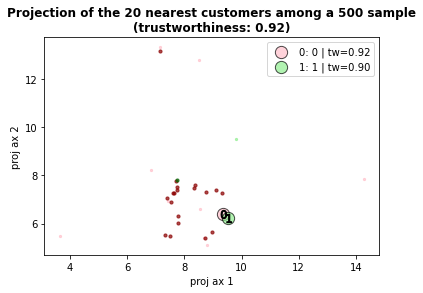

In [17]:
# Projection of a sample of the training set, colored with target value

fig, ax = plt.subplots()

proj = 'UMAP'

# show random sample
plot_projection(X=X_tr_featsel.loc[random_samp],
                y=y_train.loc[random_samp],
                model=None,
                plot_only_idx = display_samp,
                dict_proj = dict_proj,
                dict_proj_centers = dict_proj_centers,
                ser_clust = y_train.loc[random_samp],
                proj=proj, # PCA, UMAP, t-SNE
                tw_n_neigh=5, title="Projection of the 20 nearest customers among a 500 sample",
                bboxtoanchor=None, figsize=(10, 6), size=5, palette=['pink','lightgreen'],
                show_centers=True, legend_on=True, fig=fig, ax=ax, random_state=14)

# show nearest neighbors
plot_projection(X=X_tr_featsel.loc[random_samp],
                y=y_train.loc[random_samp],
                model=None,
                plot_only_idx = nearest_cust_idx,
                dict_proj = dict_proj,
                dict_proj_centers = dict_proj_centers,
                ser_clust = y_train.loc[random_samp],
                proj=proj, # PCA, UMAP, t-SNE
                tw_n_neigh=None, title=None,
                bboxtoanchor=None, figsize=(10, 6), size=10, palette=['darkred','darkgreen'],
                show_centers=False, legend_on=True, fig=fig, ax=ax, random_state=14)

# show nearest neighbors
plot_projection(X=X_tr_featsel.loc[random_samp],
                y=y_train.loc[random_samp],
                model=None,
                plot_only_idx = [customer_idx],
                dict_proj = dict_proj,
                dict_proj_centers = dict_proj_centers,
                ser_clust = y_train.loc[random_samp],
                proj=proj, # PCA, UMAP, t-SNE
                tw_n_neigh=None, title=None,
                bboxtoanchor=None, figsize=(10, 6), size=50, palette=['k'],
                show_centers=False, legend_on=True, fig=fig, ax=ax, random_state=14)

In [18]:
X_te_featsel.loc[customer_idx:customer_idx]

,binary__CODE_GENDER,high_card__OCCUPATION_TYPE,high_card__ORGANIZATION_TYPE,Bur_CB_AMT_CREDIT_MAX_OVERDUE__max,PA_PrLCash_SK_DPD_DEF__mean__mean,PA_DAYS_FIRST_DUE__min,Bur_CB_AMT_CREDIT_SUM_LIMIT__sum,PA_DAYS_LAST_DUE_1ST_VERSION__min,PA_PrLI_DELAY_DAYS_INSTALMENT__max__max,Bur_CB_DAYS_CREDIT_ENDDATE__max,...,PA_DAYS_TOT_DURATION__mean,ANNUITY_INCOME_PERC,PA_DAYS_TOT_DURATION__sum,EXT_SOURCE_3,PA_AMT_CREDIT__sum,PA_AMT_ANNUITY__mean,PA_CNT_PAYMENT__mean,AMT_CREDIT,PAYMENT_RATE,DAYS_BIRTH
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
384884,1.00,0.05,0.09,0.01,-0.17,-0.01,-0.22,-0.05,0.02,0.33,...,-0.62,-1.42,-0.70,-1.63,0.28,0.55,2.07,-1.36,3.00,-1.06


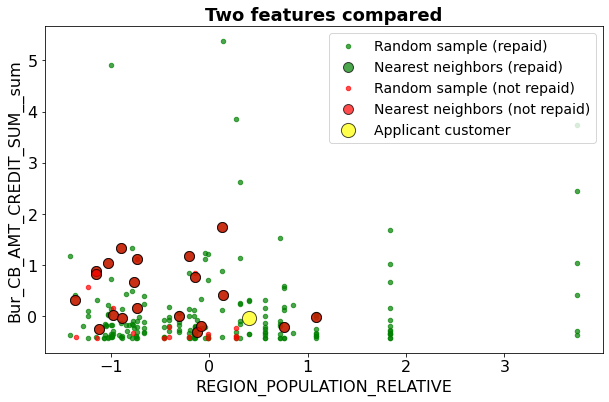

In [22]:
customer_idx = 100028

plot_scatter_projection(X=X_tr_featsel.loc[random_samp],
                        ser_clust=y_train.loc[random_samp].replace({0: 'repaid', 1: 'not repaid'}),
                        n_display = 200,
                        plot_highlight = X_tr_featsel.loc[nearest_cust_idx],
                        X_cust = X_te_featsel.loc[customer_idx:customer_idx],
                        figsize=(10, 6),
                        size=20,
                        fontsize=16,
                        columns=X_tr_featsel.columns[20:22]);

## 3 Boxplot of 10 main variables

In [23]:
X_all = X_tr_featsel.loc[random_samp]
y_all = y_train.loc[random_samp].replace({0: 'repaid (global)',
                                          1: 'not repaid (global)'})
X_neigh = X_tr_featsel.loc[nearest_cust_idx]
y_neigh = y_train.loc[nearest_cust_idx].replace({0: 'repaid (neighbors)',
                                                 1: 'not repaid (neighbors)'})
X_cust = X_te_featsel.loc[customer_idx]
main_cols = ['binary__CODE_GENDER', 'high_card__OCCUPATION_TYPE', 'high_card__ORGANIZATION_TYPE',
             'INCOME_CREDIT_PERC', 'EXT_SOURCE_2', 'ANNUITY_INCOME_PERC', 'EXT_SOURCE_3', 'AMT_CREDIT',
             'PAYMENT_RATE', 'DAYS_BIRTH']

In [24]:
X_all.shape, y_all.shape, X_neigh.shape, y_neigh.shape, X_cust.shape

((5000, 41), (5000,), (20, 41), (20,), (41,))

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 45.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


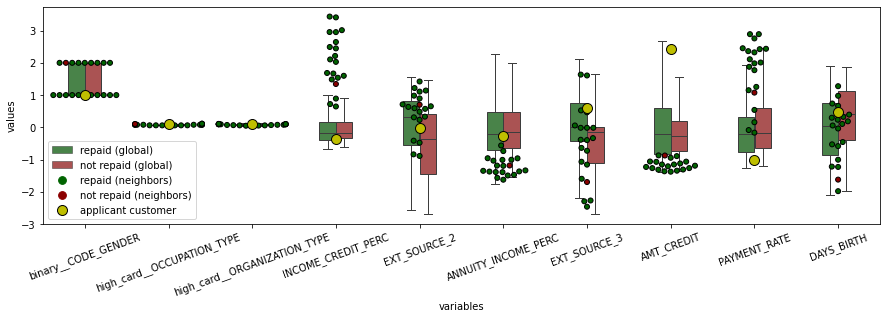

In [25]:
fig = plot_boxplot_var_by_target(X_all, y_all, X_neigh, y_neigh, X_cust,
                                 main_cols, figsize=(15,4))

## 4 SHAP graphs

In [60]:
import shap

In [61]:
shap.__version__

'0.37.0'

In [62]:
# refit the classifier to avoid 'objective' value error in shap...
clf_step.fit(X_tr_featsel, y_train)

LGBMClassifier(extra_trees=True, is_unbalance=True,
               learning_rate=0.034600991954157015, max_depth=3,
               n_estimators=1071, num_leaves=85, random_state=14,
               reg_alpha=0.001815601938420407, reg_lambda=0.1168368098621301)

In [66]:
# create the shap tree explainer of our classifier
explainer = shap.TreeExplainer(clf_step, model_output='raw')

In [67]:
# X_all, y_all, X_neigh, y_neigh, X_cust, main_cols,

In [68]:
# compute the SHAP values of the 20 neighbors + customer for the model
X_cust_neigh = pd.concat([X_neigh,
                          X_cust.to_frame(customer_idx).T],
                         axis=0)

# neighbors + customer shap values
shap_val_neigh = explainer.shap_values(X_cust_neigh)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [69]:
# compute the SHAP values of the 20 neighbors + customer for the model
X_all = pd.concat([X_tr_featsel,
                   X_te_featsel], axis=0)

# shap values pour X train and test
shap_val_all = pd.DataFrame(explainer.shap_values(X_all)[1],
                            index=X_all.index,
                            columns=X_tr_featsel.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [70]:
# compute expected value (approx mean of predictions on training set)
# NB to be calculated AFTER shap values !!!!!!!!!!!!!!
expected_value = explainer.expected_value[1] # depends on the model only (already fitted on training set)
expected_value

-0.43047621229368827

In [ ]:
# shap_val_neigh.values = shap_val_neigh.values[:,:,1]
# shap_val_neigh.base_values = shap_val_neigh.base_values[:,1]

In [33]:
shap_val_neigh[1].shape, shap_val_neigh[1][-1].shape

((21, 41), (41,))

#### Feature importance for the 20 nearest neighbors of the customer

In [34]:
# get feature importance on the selected data

import numpy as np

shap_values = shap_val_neigh

# vals= np.abs(shap_values).mean(0)
vals = np.abs(shap_values[1]).mean(0)

feat_imp = pd.DataFrame(list(zip(X_cust_neigh.columns, vals)),
                                  columns=['col_name','feature_imp'])\
                           .sort_values(by=['feature_imp'], ascending=False)

most_imp_10_cols = feat_imp.iloc[:10]['col_name'].values

In [35]:
li_cols = list(feat_imp.iloc[:10]['col_name'].index)

#### Probability prediction for class 1

In [36]:
y_tr_proba = clf_step.predict_proba(X_tr_featsel)

In [37]:
y_neigh_cust_proba = clf_step.predict_proba(X_cust_neigh) 

In [43]:
# customer prediction
y_neigh_cust_proba[:,1][-1]

0.2786629058961143

In [45]:
# shapley values for customer
shap_val_neigh[1][-1]

array([ 0.        ,  0.04716136,  0.11172427, -0.03763582, -0.01567249,
       -0.01563409, -0.12095248, -0.00447458, -0.12503646,  0.03726593,
       -0.00656776, -0.00404608, -0.04093104, -0.08535496, -0.01533073,
       -0.03108285,  0.02986845,  0.01935682,  0.00134495, -0.08530978,
        0.02775411, -0.05697809, -0.02624459, -0.02009243, -0.00595334,
       -0.01958033, -0.03857838,  0.07643398,  0.07731779,  0.00299061,
        0.05499775, -0.06722687,  0.01003671, -0.0337504 , -0.31251099,
       -0.00995964,  0.06284601,  0.03038364, -0.04224891,  0.01164359,
        0.09939961])

In [47]:
y_neigh_cust_proba[:,1][-1], shap_val_neigh[1][-1].sum(), expected_value

(-0.5206275238911153, -0.43047621229368827)

In [49]:
shap_val_neigh[1][-1].sum() - expected_value

-0.09015131159742706

#### Waterfall plot for one customer

In [ ]:
# # compute shap interaction values of features (matrix)
# shap_interaction_values = explainer.shap_interaction_values()#[1] # ne dépend pas du nbe de features... (pourquoi?)

In [ ]:
# shap.plots.waterfall(expected_value, shap_val_neigh[1])

In [ ]:
# shap.waterfall_plot(expected_value,
#                     shap_val_neigh, # [1][-1]
#                     X_cust_neigh.values.reshape(-1),
# #                     feature_names=X_neigh.columns, max_display=10
#                     )

In [71]:
from scipy.special import expit #Importing the logit function for the base value transformation

def shap_transform_scale(shap_values, expected_value, model_prediction):
    #Compute the transformed base value, which consists in applying the logit function to the base value    
    expected_value_transformed = expit(expected_value)
    #Computing the original_explanation_distance to construct the distance_coefficient later on
    original_explanation_distance = sum(shap_values)
    #Computing the distance between the model_prediction and the transformed base_value
    distance_to_explain = model_prediction - expected_value_transformed
    #The distance_coefficient is the ratio between both distances which will be used later on
    distance_coefficient = original_explanation_distance / distance_to_explain
    #Transforming the original shapley values to the new scale
    shap_values_transformed = shap_values / distance_coefficient
    return shap_values_transformed, expected_value_transformed

In [84]:
# explainer.shap_values(X_cust_neigh)[1], explainer.expected_value[1], clf_step.predict_proba(X_cust_neigh)[:,1].shape

In [88]:
shap_values_trans, expected_value_trans = \
     shap_transform_scale(shap_values=explainer.shap_values(X_cust_neigh)[1][-1],
                          expected_value=explainer.expected_value[1],
                          model_prediction=clf_step.predict_proba(X_cust_neigh)[:,1][-1])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [90]:
clf_step.predict_proba(X_cust_neigh)[:,1][-1]

0.2786629058961143

In [92]:
clf_step.predict_proba(X_tr_featsel)[-1].mean()

0.5

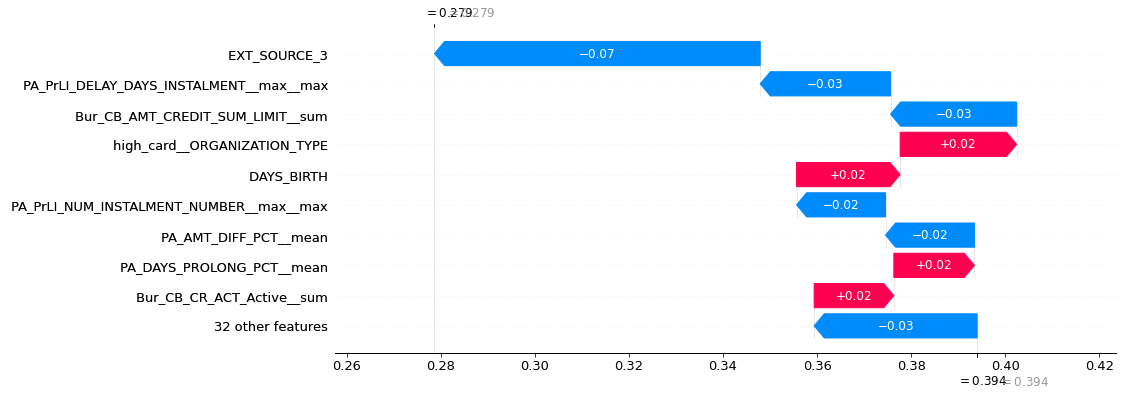

In [89]:
shap.plots._waterfall.waterfall_legacy(expected_value_trans,#expected_value,
                                       shap_values_trans,#shap_values[1][-1],
                                       X_cust_neigh.values.reshape(-1),
                                       feature_names=X_neigh.columns,
                                       max_display=10, show=False)
plt.gcf().set_size_inches((14,6))
plt.show()

In [58]:
pd.DataFrame({'shap_val': shap_val_neigh[1][-1],
              'abs_shap': np.abs(shap_val_neigh[1][-1])},
             index=X_cust_neigh.columns).sort_values(by='abs_shap', ascending=False)

,shap_val,abs_shap
EXT_SOURCE_3,-0.31,0.31
PA_PrLI_DELAY_DAYS_INSTALMENT__max__max,-0.13,0.13
Bur_CB_AMT_CREDIT_SUM_LIMIT__sum,-0.12,0.12
high_card__ORGANIZATION_TYPE,0.11,0.11
DAYS_BIRTH,0.10,0.10
PA_PrLI_NUM_INSTALMENT_NUMBER__max__max,-0.09,0.09
PA_AMT_DIFF_PCT__mean,-0.09,0.09
PA_DAYS_PROLONG_PCT__mean,0.08,0.08
Bur_CB_CR_ACT_Active__sum,0.08,0.08
PA_DAYS_TOT_DURATION__mean,-0.07,0.07


#### Forceplot

In [59]:
shap.initjs()
shap.force_plot(expected_value,
                shap_val_neigh[1][-1],
                X_neigh.columns,
                show=True)
# plt.gcf().set_size_inches(3,6)
# plt.show()

#### Beeswarm plot for 20 neighbors and the customer

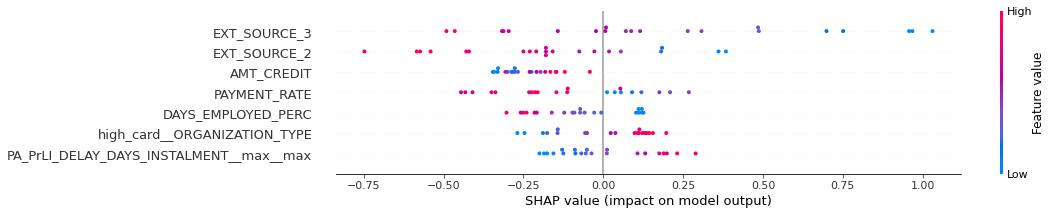

In [93]:
shap.summary_plot(shap_values[1], # shap values
                  X_cust_neigh.values, # data (np.array)
                  feature_names=X_neigh.columns, # features name of data (order matters)
                  max_display=7, # nb of displayed features
                  show=False, # enables setting of plot size later using matplotlib
#                   plot_type="dot",
                      color=plt.get_cmap("tab10"),
                 ) 
# Change size of the figure
plt.gcf().set_size_inches((14,3))

# # Change the colormap of the artists
# my_cmap = plt.get_cmap('seismic')
# for fc in plt.gcf().get_children():
#     for fcc in fc.get_children():
#         if hasattr(fcc, "set_cmap"):
#             fcc.set_cmap(my_cmap)
plt.show()


In [ ]:
shap_values[1][-2:-1].shape

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

shap.summary_plot(shap_values[1],#[:-1],
                  X_cust_neigh.values,#[:-1],
                  feature_names=X_neigh.columns,
                  max_display=10,
                  show=False,
                  plot_size=None,
#                   color_bar=False
                 )
# Change the colormap of the artists
my_cmap =  plt.get_cmap('seismic')
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)

# shap.summary_plot(shap_values[1],
#                   X_cust_neigh.values,
#                   feature_names=X_neigh.columns,
#                   max_display=10,
#                   show=False,
# #                   plot_size=None,
#                  )

plt.show()

In [98]:
pd.Series(clf_step.feature_importances_,
          index=X_te_featsel.columns).sort_values(ascending=False)

PAYMENT_RATE                                   557
EXT_SOURCE_3                                   345
Bur_CB_DAYS_CREDIT_ENDDATE__max                289
DAYS_BIRTH                                     289
EXT_SOURCE_2                                   288
AMT_CREDIT                                     287
PA_DAYS_PROLONG_PCT__mean                      249
DAYS_EMPLOYED_PERC                             225
Bur_CB_AMT_CREDIT_SUM__sum                     215
PA_AMT_CREDIT__sum                             210
Bur_CB_AMT_CREDIT_SUM_DEBT__sum                206
high_card__ORGANIZATION_TYPE                   199
PA_DAYS_TOT_DURATION__mean                     195
PA_DAYS_FIRST_DUE__min                         190
PA_CNT_PAYMENT__mean                           183
PA_PrLI_DELAY_DAYS_INSTALMENT__max__max        183
Bur_CB_DAYS_CREDIT__abs_min                    181
PA_PrLI_NUM_INSTALMENT_NUMBER__max__max        177
Bur_CB_AMT_CREDIT_MAX_OVERDUE__max             176
Bur_CB_CR_ACT_Active__sum      